<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predvidjanje vrednosti Bitcoina pomocu GRU (Gated Recurrent Unit), RNN**

**Atributi:** Close

**Filtrirani podaci:** od 28.03.2021.

## **Ucitavanje biblioteka**

In [4]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
#from keras.utils import np_utils
from keras.layers import GRU,CuDNNGRU
from keras.callbacks import CSVLogger, ModelCheckpoint
#import h5py
import os
from keras.losses import MeanSquaredError
#import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session

## **Ucitavanje skupa podataka i pretprocesiranje**

In [5]:
# Ucitavanje skupa podataka

data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Ciscenje podataka od NaN vrednosti

data = data.dropna()
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [7]:
# Kreiranje datuma

data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)


# Filtriranje podataka

data = data.loc[data['Date'] > pd.to_datetime('2021-03-28')]
data.head(4)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4854496,1616976000,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695,2021-03-29
4854497,1616976060,55822.98,55857.28,55822.98,55857.28,0.589603,32931.781301,55854.182542,2021-03-29
4854498,1616976120,55822.98,55829.04,55766.15,55779.04,2.729659,152263.034630,55780.964698,2021-03-29
4854500,1616976240,55766.15,55768.63,55766.15,55768.63,0.023738,1323.776861,55766.455065,2021-03-29


In [8]:
# Dimenzije DataFrame-a

data.shape

(2872, 9)

## **Podela skupa, vizualizacija, priprema trening i validacionog skupa**

### **Podela skupa podataka**

In [9]:
# Definicija funkcije za podelu podataka na train i test skup

def data_split(data, test_size = 0, days_to_predict = 0):

  if test_size == 0 and days_to_predict == 0:
    print('Uneti vrednost za jedan od parametara test_size ili days_to_predict.\n')
    return
  elif test_size == 0: # dato je days_to_predict
    test_limit = len(data) - prediction_days
  else: # dato je test_size ili oba parametra
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

In [10]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2, days_to_predict = 0)

In [11]:
# Dimenzije train i test skupa

train.shape, test.shape

((2298, 9), (574, 9))

### **Vizualizacija podataka**

In [12]:
# Definicija funkcije za vizuelni prikaz train i test podataka

def plot_data(train_data = train['Close'], test_data = test['Close']):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(train_data, label='trening', linewidth=2)
  ax.plot(test_data, label='test', linewidth=2)
  ax.set_ylabel('cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz skupova za trening i test', fontsize=18)
  ax.legend(loc='best', fontsize=18)

  #data = data.reset_index()
  #x = data.index
  #ax.set_xticks(range(87724))


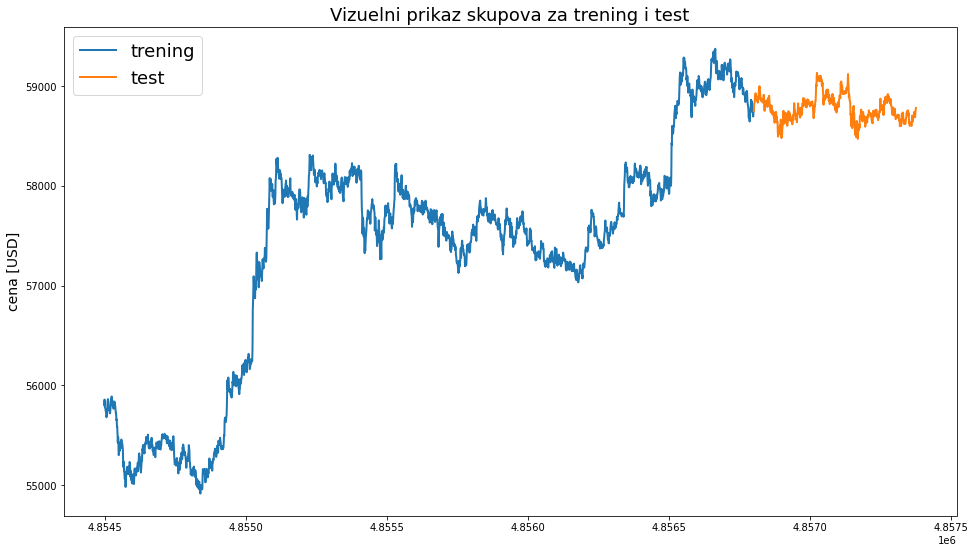

In [13]:
# Plotovanje train i test skupa podataka

plot_data(train_data = train['Close'], test_data = test['Close'])

### **Priprema trening skupa**

**Filtriranje atributa train skupa**

In [14]:
# Izbacivanje nepotrebnih kolona (atributa) iz train skupa

train_ = train.drop(['Open', 'High', 'Low', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head()

,Close
4854496,55804.36
4854497,55857.28
4854498,55779.04
4854500,55768.63
4854501,55742.20


In [15]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((2298, 9), (2298, 1))

**Skaliranje train skupa**

In [16]:
# Skaliranje trening skupa

scaler = MinMaxScaler(feature_range=(0, 1))
train_ = scaler.fit_transform(train_)
train_

array([[0.19947492],
       [0.21134984],
       [0.19379327],
       ...,
       [0.84805843],
       [0.84788789],
       [0.86661356]])

**Odredjivanje ciljne promenljive na train skupu**

In [17]:
# Odredjivanje ciljne promenljive na train skupu

X_train = []
y_train = []

for i in range(60, train_.shape[0]):
    X_train.append(train_[i-60:i])
    y_train.append(train_[i,0])

In [18]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
# Ispis X_train skupa

X_train

array([[[0.19947492],
        [0.21134984],
        [0.19379327],
        ...,
        [0.10581068],
        [0.10379113],
        [0.12109414]],

       [[0.21134984],
        [0.19379327],
        [0.19145733],
        ...,
        [0.10379113],
        [0.12109414],
        [0.12154293]],

       [[0.19379327],
        [0.19145733],
        [0.1855266 ],
        ...,
        [0.12109414],
        [0.12154293],
        [0.11767887]],

       ...,

       [[0.94526136],
        [0.94903342],
        [0.93838593],
        ...,
        [0.86948805],
        [0.85748297],
        [0.86717903]],

       [[0.94903342],
        [0.93838593],
        [0.94028206],
        ...,
        [0.85748297],
        [0.86717903],
        [0.84805843]],

       [[0.93838593],
        [0.94028206],
        [0.94762872],
        ...,
        [0.86717903],
        [0.84805843],
        [0.84788789]]])

In [20]:
# Dimenzije X_train

X_train.shape, y_train.shape

((2238, 60, 1), (2238,))

### **Priprema validacionog skupa**

In [21]:
# 80% podataka ce biti ostavljeno u trening skupu
# 20% podataka za validacioni skup

training_size = int(0.8* X_train.shape[0])

training_data = X_train[:training_size]
training_labels = y_train[:training_size]

validation_data = X_train[training_size:]
validation_labels = y_train[training_size:]

In [22]:
# Dimenzije

validation_data.shape, validation_labels.shape, training_data.shape, training_labels.shape

((448, 60, 1), (448,), (1790, 60, 1), (1790,))

In [23]:
# Ispis trening i validacionih skupova

print('Training data:\n', training_data)
print('\nTraining labels:\n', training_labels)
print('\nValidation data:\n', validation_data)
print('\nValidation labels:\n', validation_labels)

Training data:
 [[[0.19947492]
  [0.21134984]
  [0.19379327]
  ...
  [0.10581068]
  [0.10379113]
  [0.12109414]]

 [[0.21134984]
  [0.19379327]
  [0.19145733]
  ...
  [0.10379113]
  [0.12109414]
  [0.12154293]]

 [[0.19379327]
  [0.19145733]
  [0.1855266 ]
  ...
  [0.12109414]
  [0.12154293]
  [0.11767887]]

 ...

 [[0.57813731]
  [0.58218986]
  [0.57972153]
  ...
  [0.74438623]
  [0.74153194]
  [0.73031   ]]

 [[0.58218986]
  [0.57972153]
  [0.5839895 ]
  ...
  [0.74153194]
  [0.73031   ]
  [0.72829494]]

 [[0.57972153]
  [0.5839895 ]
  [0.59564452]
  ...
  [0.73031   ]
  [0.72829494]
  [0.72409878]]]

Training labels:
 [0.12154293 0.11767887 0.11212063 ... 0.72829494 0.72409878 0.7331598 ]

Validation data:
 [[[0.5839895 ]
  [0.59564452]
  [0.60213399]
  ...
  [0.72829494]
  [0.72409878]
  [0.7331598 ]]

 [[0.59564452]
  [0.60213399]
  [0.61005958]
  ...
  [0.72409878]
  [0.7331598 ]
  [0.72415263]]

 [[0.60213399]
  [0.61005958]
  [0.61087413]
  ...
  [0.7331598 ]
  [0.72415263]
  [

## **Kreiranje, kompilacija i treniranje mreze**

### **Kreiranje mreze**

In [24]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(step_size = X_train.shape[1], units = 50, nb_features = X_train.shape[2], output_size = 16):

  net = Sequential()
  net.add(GRU(units = units, input_shape = (step_size, nb_features), return_sequences=False))
  net.add(Activation('tanh'))
  net.add(Dropout(0.2))
  net.add(Dense(output_size))
  net.add(Activation('relu'))
  
  print(net.summary())

  return net


In [25]:
# Zadavanje parametara

step_size = X_train.shape[1]
units = 50
nb_features = X_train.shape[2]
output_size = 16

In [26]:
# Kreiranje modela mreze

net = build_net(step_size = X_train.shape[1], units = 50, nb_features = X_train.shape[2], output_size = 16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
Total params: 8,766
Trainable params: 8,766
Non-trainable params: 0
_________________________________________________________________
None


### **Kompilacija i treniranje mreze**

In [27]:
# Definicija funkcije za kompilaciju i treniranje mreze
# Treniranje je moguce vrsiti sa ili bez validacije

def compile_and_fit(validation_data, validation_labels, optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy', 'mae'], X_train_ = X_train, y_train_ = y_train, epochs = 20, validation = 0.1, batch_size = 50):

  net.compile(loss = loss, optimizer = optimizer, metrics = metrics)

  if validation == 0:
    history = net.fit(X_train_, y_train_, batch_size = batch_size, epochs = epochs, callbacks = [CSVLogger(output_file_name + '.csv', append = True), ModelCheckpoint('weights/' + output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min')])
  else:
    history = net.fit(X_train_, y_train_, batch_size = batch_size, validation_data = (validation_data, validation_labels), epochs = epochs, callbacks=[CSVLogger(output_file_name + '.csv', append = True), ModelCheckpoint('weights/' + output_file_name + '-{epoch:02d}-{val_loss:.5f}.hdf5', monitor = 'val_loss', verbose = 1, mode = 'min')])

  return history, net


In [28]:
# zadavanje parametara

output_file_name='bitcoin_close_GRU_tanh_relu_'
batch_size = 8
epochs = 100

optimizer = 'adam'
loss = 'mean_squared_error'
metrics = ['accuracy', 'mae']


In [29]:
# Kompilacija i treniranje mreze sa validacijom

print('Treniranje sa validacijom\n')
history_validation, net_validation = compile_and_fit(validation_data, validation_labels, optimizer = optimizer, loss = loss, metrics = metrics, X_train_ = training_data, y_train_ = training_labels, epochs = epochs, batch_size = batch_size)


# Kompilacija i treniranje mreze bez validacije

print('\nTreniranje bez validacije\n')
history_no_validation, net_no_validation = compile_and_fit(validation_data, validation_labels, optimizer = optimizer, loss = loss, metrics = metrics, X_train_ = training_data, y_train_ = training_labels, epochs = epochs, batch_size = batch_size)


Treniranje sa validacijom

Epoch 1/100
224/224 [==============================] - 25s 26ms/step - loss: 0.0930 - accuracy: 0.0000e+00 - mae: 0.2199 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - val_mae: 0.0349

Epoch 00001: saving model to weights/bitcoin_close_GRU_tanh_relu_-01-0.00212.hdf5
Epoch 2/100
224/224 [==============================] - 5s 23ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - mae: 0.0577 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mae: 0.0344

Epoch 00002: saving model to weights/bitcoin_close_GRU_tanh_relu_-02-0.00151.hdf5
Epoch 3/100
224/224 [==============================] - 5s 23ms/step - loss: 0.0040 - accuracy: 0.0000e+00 - mae: 0.0466 - val_loss: 0.0020 - val_accuracy: 0.0000e+00 - val_mae: 0.0417

Epoch 00003: saving model to weights/bitcoin_close_GRU_tanh_relu_-03-0.00201.hdf5
Epoch 4/100
224/224 [==============================] - 5s 23ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - mae: 0.0394 - val_loss: 8.1903e-04 - val_accuracy: 0.0000e+00 -

## **Priprema test skupa**

### **Filtriranje atributa test skupa**

In [30]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Open', 'High', 'Low', 'Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)


### **Skaliranje test skupa**

In [31]:
# Skaliranje test skupa

test_ = scaler.transform(test_)

### **Odredjivanje ciljne promenljive na test skupu**

In [32]:
# Odredjivanje ciljne (target) promenljive na test skupu

X_test = []
y_test = []

for i in range(60, test_.shape[0]):
    X_test.append(test_[i-60:i])
    y_test.append(test_[i,0])
    

In [33]:
# Konverzija u np.array

X_test, y_test = np.array(X_test), np.array(y_test)

## **Predvidjanje**

In [34]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

Predvidjene vrednosti - bez validacije:
 [[0.8533192  0.8533193  0.8533192  ... 0.8533192  0.8533193  0.8533192 ]
 [0.85070753 0.85070753 0.85070753 ... 0.85070753 0.85070753 0.85070753]
 [0.8526641  0.8526641  0.8526641  ... 0.8526641  0.8526641  0.8526641 ]
 ...
 [0.8391645  0.83916444 0.83916444 ... 0.83916444 0.8391644  0.8391644 ]
 [0.8464963  0.8464963  0.8464963  ... 0.84649634 0.84649634 0.84649634]
 [0.8543952  0.8543952  0.8543952  ... 0.8543952  0.8543952  0.8543952 ]]

Predvidjene vrednosti - sa validacijom:
 [[0.8533192  0.8533193  0.8533192  ... 0.8533192  0.8533193  0.8533192 ]
 [0.85070753 0.85070753 0.85070753 ... 0.85070753 0.85070753 0.85070753]
 [0.8526641  0.8526641  0.8526641  ... 0.8526641  0.8526641  0.8526641 ]
 ...
 [0.8391645  0.83916444 0.83916444 ... 0.83916444 0.8391644  0.8391644 ]
 [0.8464963  0.8464963  0.8464963  ... 0.84649634 0.84649634 0.84649634]
 [0.8543952  0.8543952  0.8543952  ... 0.8543952  0.8543952  0.8543952 ]]


## **Vizualizacija rezultata predvidjanja i metrika**

In [35]:
# Vizuelni prikaz rezultata modela mreze

def plot_real_vs_predicted_data(test_set, predicted_set, caption):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(test_set, label='Stvarna vrednost BTC', linewidth=2)
  ax.plot(predicted_set, label='Predvidjena vrednost BTC', linewidth=2)
  ax.set_xlabel('Timestamp', fontsize=14)
  ax.set_ylabel('Cena [USD]', fontsize=14)
  ax.set_title(label = caption, fontsize=18)
  ax.legend(loc='best', fontsize=18)

  # test = test.reset_index()
  # x = test.index


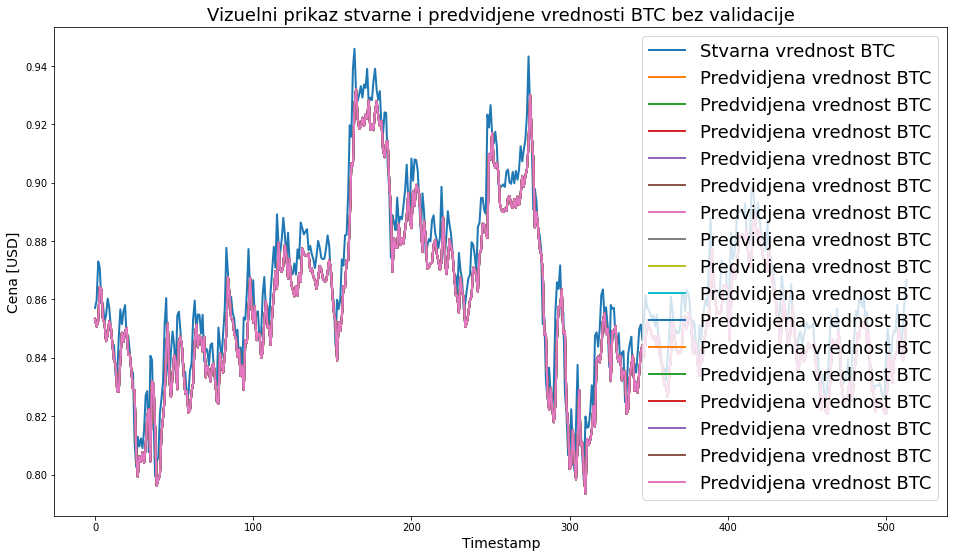

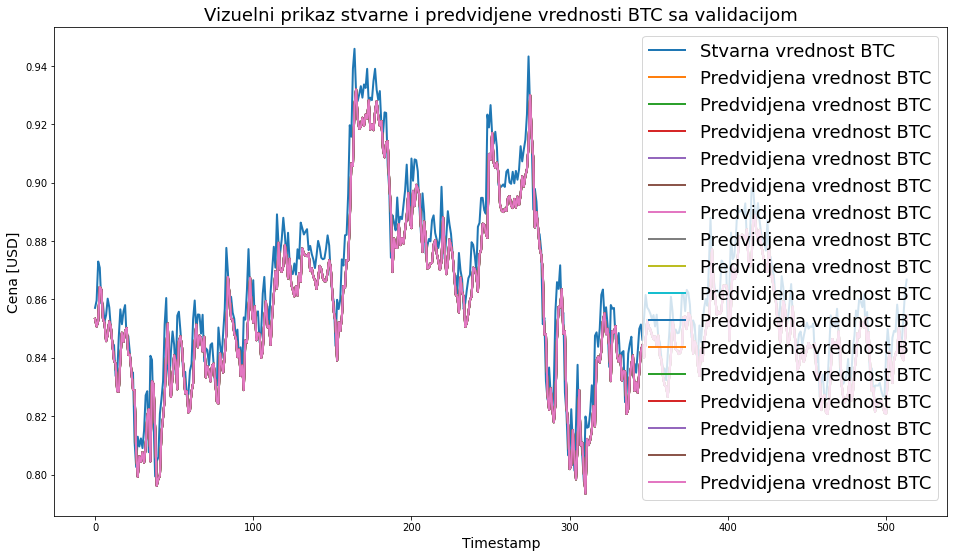

In [36]:
# Plotovanje stvarne i predvidjene vrednosti


# Bez validacije

plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation, caption = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC bez validacije')


# Sa validacijom

plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_validation, caption = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC sa validacijom')

In [37]:
# Vizuelni prikaz gubitka i tacnosti tokom treniranja mreze

# Ukoliko je validacija nije koriscena tokom treniranja mreze,
# onda parametar is_validation_used treba biti 0, a inace 1

def plot_loss_and_accuracy(history_, is_validation_used):

  epochs = range(len(history_.history['loss'])) # broj epoha

  plt.title('Vizuelni prikaz gubitka (loss) i tacnosti (accuracy) mreze')


  # Gubitak

  plt.subplot(211)
  
  plt.plot(epochs, history_.history['loss'], label='Gubitak (loss) tokom treniranja')

  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_loss'], label='Gubitak (val_loss) tokom validacije')
  
  plt.legend()


  # Tacnost

  plt.subplot(212)

  plt.plot(epochs, history_.history['accuracy'], label='Tacnost (accuracy) tokom treniranja')
  
  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_accuracy'], label='Tacnost (val_accuracy) tokom validacije')
  
  plt.legend()

  plt.show()


Bez validacije



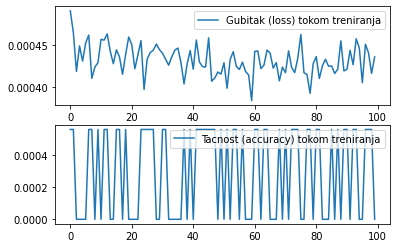


Sa validacijom



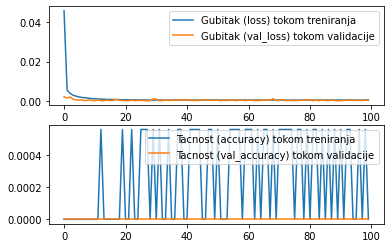

In [38]:
# Plotovanje gubitka i tacnosti mreze tokom treniranja

# Bez validacije

print('Bez validacije\n')
plot_loss_and_accuracy(history_ = history_no_validation, is_validation_used = 0)


# Sa validacijom

print('\nSa validacijom\n')
plot_loss_and_accuracy(history_ = history_validation, is_validation_used = 1)

In [39]:
# Dimenzije vektora stvarnih i vektora predvidjenih vrednosti y

y_test.shape, y_predicted_no_validation.shape

((514,), (514, 16))

In [40]:
# Uzima se prosecna vrednost predvidjenih

mean_vals = []

for row in y_predicted_no_validation:
  mean_vals.append(row.mean())

mean_vals[:10]

[0.8533193,
 0.85070753,
 0.8526641,
 0.8642458,
 0.86332667,
 0.85344505,
 0.85177994,
 0.84568584,
 0.84793174,
 0.8524643]

In [41]:
# Duzina liste mean_vals

len(mean_vals)

514

In [42]:
# Racunanje MSE za y_predicted_no_validation

mse = MeanSquaredError()

mse(y_test, mean_vals).numpy()

0.00012961225

In [43]:
# Racunanje MSE za y_predicted_validation

mean_vals_ = []

for row in y_predicted_validation:
  mean_vals_.append(row.mean())

mse(y_test, mean_vals_).numpy()

0.00012961225

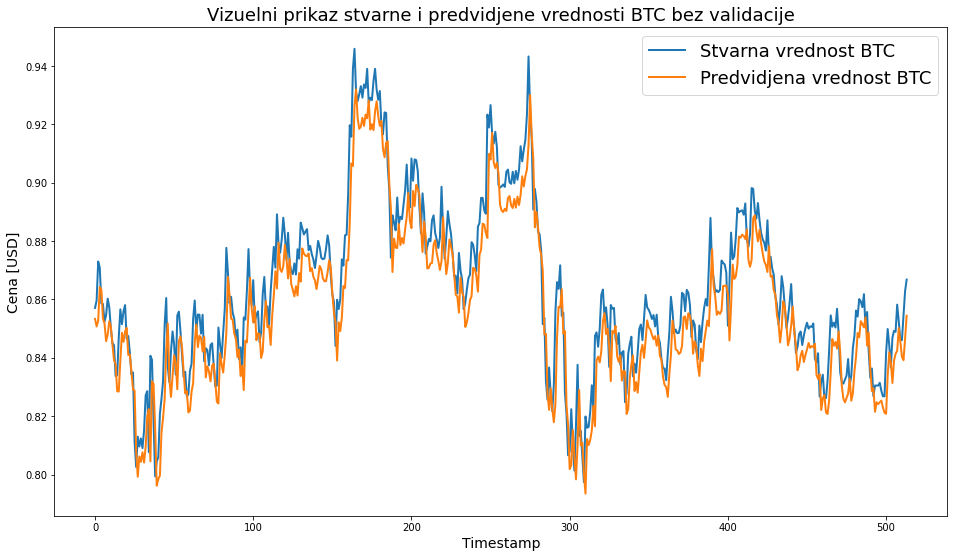

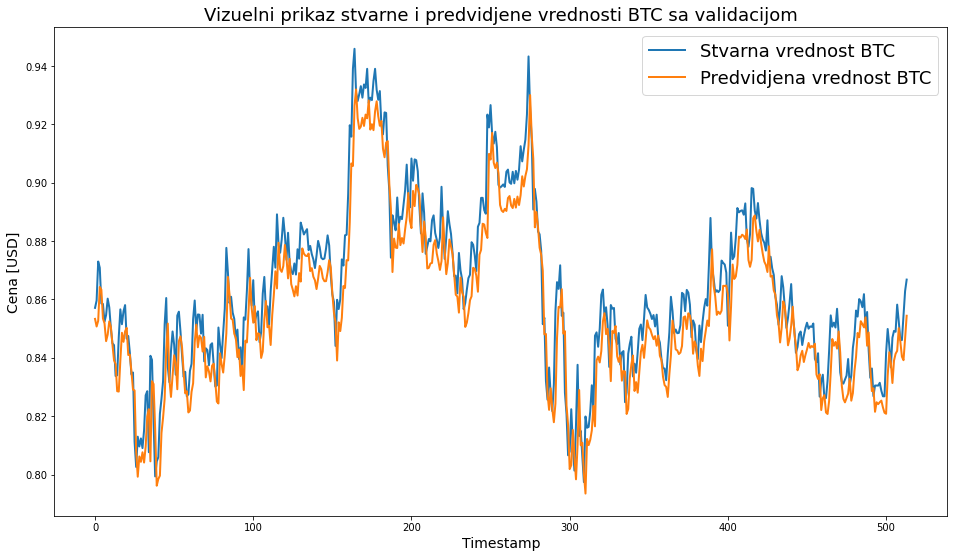

In [44]:
# Plotovanje stvarne i predvidjene vrednosti (prosecne vrednosti predvidjenih)


# Bez validacije

plot_real_vs_predicted_data(test_set = y_test, predicted_set = mean_vals, caption = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC bez validacije')


# Sa validacijom

plot_real_vs_predicted_data(test_set = y_test, predicted_set = mean_vals_, caption = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC sa validacijom')

In [45]:
# Vizuelni prikaz MAE

def plot_mae(history_):

  epochs = range(len(history_.history['mae'])) # broj epoha
  plt.title('Vizuelni prikaz MAE (mae')
  plt.xlabel('broj epohe')
  plt.ylabel('MAE')
  
  plt.plot(epochs, history_.history['mae'], label='MAE (mae) tokom treniranja')

  if 'val_mae' in history_.history:
    plt.plot(epochs, history_.history['val_mae'], label='MAE (val_mae) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()

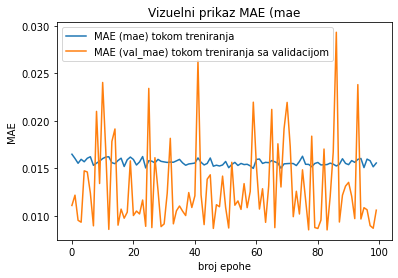

In [46]:
# MAE

plot_mae(history_no_validation)

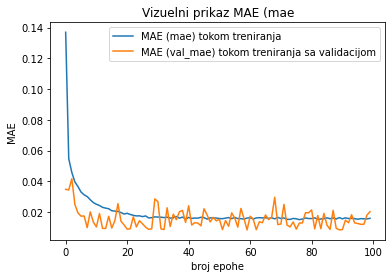

In [47]:
# MAE - sa validacijom

plot_mae(history_validation)

In [48]:
# Loss, accuracy, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])

17/17 [==============================] - 0s 8ms/step - loss: 1.2961e-04 - accuracy: 0.0000e+00 - mae: 0.0091

Metrike prilikom testiranja - model treniran bez validacije

loss 0.00012961222091689706
accuracy 0.0
mae 0.009136010892689228


Metrike prilikom testiranja - model treniran sa validacijom

loss 0.00012961222091689706
accuracy 0.0
mae 0.009136010892689228


In [54]:
y_predicted_no_validation.shape, y_test.shape

((514, 16), (514,))

In [58]:
len(mean_vals), len(mean_vals_)

(514, 514)

In [59]:
# R2 skor nad skupom za testiranje
from sklearn.metrics import r2_score

r2 = r2_score(mean_vals, y_test)
r2_val = r2_score(mean_vals_, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije 0.8268360080548638
R2 skor prilikom testiranja - model treniran sa validacijom 0.8268360080548638
